In [ ]:
# Este comando instala todas as bibliotecas de Python necessárias para o projeto. A opção "-q" reduz a quantidade de mensagens durante a instalação.
!pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.2 MB/s eta 0:00:00


In [2]:
# Módulos Essenciais
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import unidecode
import torch
from IPython.display import display
import joblib # Para salvar os modelos

# Módulos do Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Módulos do PyTorch e Transformers (Hugging Face)
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Configurações de Reprodutibilidade
# Definir sementes aleatórias para NumPy e PyTorch. Isso garante que qualquer processo com componente aleatório (como divisão de dados ou inicialização de pesos de modelo) produza sempre os mesmos resultados, tornando o experimento científico reprodutível.
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Configurações de Pré-processamento (NLTK)
# Baixa os pacotes necessários do NLTK para processamento de texto em português.
nltk.download("stopwords", quiet=True)
nltk.download("rslp", quiet=True)

# Define a lista de stopwords e o algoritmo de stemming para português.
stopwords_pt = nltk.corpus.stopwords.words("portuguese")
stemmer_pt = nltk.stem.RSLPStemmer()

# Configuração do Dispositivo de Treinamento (GPU/CPU)
# Verifica se uma GPU está disponível e a define como dispositivo de treinamento para o PyTorch. O treinamento do BERT é significativamente mais rápido em GPU "cuda".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de treinamento configurado para: {device}")

Dispositivo de treinamento configurado para: cuda


In [3]:
# Carregamento e Preparação dos Dados

# O repositório Fake.br-Corpus é clonado do GitHub para ter acesso local ao dataset.
# Esta é a fonte de dados primária para o estudo.
if not os.path.exists('Fake.br-Corpus'):
    print("Clonando o repositório Fake.br-Corpus...")
    !git clone https://github.com/roneysco/Fake.br-Corpus.git --quiet

# Carrega o arquivo CSV pré-processado do corpus para um DataFrame do Pandas.
df = pd.read_csv("Fake.br-Corpus/preprocessed/pre-processed.csv")

# Renomeia as colunas para nomes mais intuitivos e define o índice.
df.set_index('index', inplace=True)
df.columns = ['classe', 'texto']

# Padroniza os rótulos da coluna 'classe' para 'falsa' e 'verdadeira'.
df['classe'] = df['classe'].apply(lambda x: 'falsa' if x == 'fake' else 'verdadeira')

# Exibe as 5 primeiras linhas para uma verificação inicial dos dados.
print("Amostra dos dados carregados:")
display(df.head())

# Exibe a contagem de cada classe para verificar se o dataset está balanceado.
print("\nDistribuição das classes no dataset:")
print(df['classe'].value_counts())

Clonando o repositório Fake.br-Corpus...
Amostra dos dados carregados:


,classe,texto
index,,
0,falsa,katia abreu diz vai colocar expulsao moldura n...
1,falsa,ray peita bolsonaro conservador fake entrevist...
2,falsa,reinaldo azevedo desmascarado policia federal ...
3,falsa,relatorio assustador bndes mostra dinheiro pub...
4,falsa,radialista americano fala sobre pt vendem ilus...



Distribuição das classes no dataset:
classe
falsa         3600
verdadeira    3600
Name: count, dtype: int64


In [4]:
# Bloco 4: Pré-processamento do Texto

def preprocess_text(text):
    """
    Aplica uma série de etapas de limpeza e normalização em um texto para prepará-lo
    para os modelos de machine learning clássicos.

    Args:
        text (str): O texto original a ser processado.

    Returns:
        str: O texto limpo, normalizado e com stemming aplicado.
    """
    # 1. Converte para minúsculas
    text = str(text).lower()
    # 2. Remove acentos
    text = unidecode.unidecode(text)
    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # 4. Remove números
    text = re.sub(r"\d+", "", text)
    # 5. Remove pontuação
    text = re.sub(r"[^\w\s]", "", text)
    # 6. Tokeniza o texto (divide em palavras)
    tokens = text.split()
    # 7. Remove stopwords e aplica stemming
    tokens = [stemmer_pt.stem(word) for word in tokens if word not in stopwords_pt]

    return " ".join(tokens)

# Aplica a função de pré-processamento a todos os textos do DataFrame.
# O resultado é armazenado em uma nova coluna para manter o texto original.
print("Aplicando pré-processamento aos textos...")
df["texto_limpo"] = df["texto"].apply(preprocess_text)

print("Amostra dos dados com texto limpo:")
display(df[['classe', 'texto_limpo']].head())

Aplicando pré-processamento aos textos...
Amostra dos dados com texto limpo:


,classe,texto_limpo
index,,
0,falsa,kat abr diz vai coloc expulsa mold nao reclam ...
1,falsa,ray peit bolsonar conserv fak entrev danil gen...
2,falsa,reinald azeved desmascar polic feder ferrenh c...
3,falsa,relatori assust bnd mostr dinh publ brasil jor...
4,falsa,radial americ fal sobr pt vend ilusa pov brasi...


In [5]:
# Divisão e Vetorização (TF-IDF com N-grams)

# Divide o dataset em 80% para treino e 20% para teste.
# 'stratify=df["classe"]' garante que a proporção de classes seja a mesma nos conjuntos de treino e teste, evitando viés.
X_train, X_test, y_train, y_test = train_test_split(
    df["texto_limpo"], df["classe"], test_size=0.2, random_state=42, stratify=df["classe"]
)

# Vetorização com TF-IDF: transforma texto em vetores numéricos.
# - max_features=10000: Limita o vocabulário às 10.000 features mais relevantes.
# - ngram_range=(1, 2): Considera palavras individuais (unigrams) e pares de palavras consecutivas (bigrams), capturando um pouco mais de contexto.
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Aprende o vocabulário e transforma os dados de treino.
X_train_tfidf = vectorizer.fit_transform(X_train)
# Apenas transforma os dados de teste, usando o vocabulário já aprendido.
X_test_tfidf = vectorizer.transform(X_test)

print(f"Dimensões da matriz de treino (TF-IDF): {X_train_tfidf.shape}")
print(f"Dimensões da matriz de teste (TF-IDF): {X_test_tfidf.shape}")

Dimensões da matriz de treino (TF-IDF): (5760, 10000)
Dimensões da matriz de teste (TF-IDF): (1440, 10000)


In [6]:
# Treinamento e Otimização dos Modelos Clássicos

# Para cada modelo, usamos GridSearchCV para testar diferentes hiperparâmetros e encontrar a melhor combinação através de validação cruzada (cv=5).

# Otimização do SVM (LinearSVC)
print("Iniciando otimização para o SVM...")
param_grid_svm = {'C': [0.1, 1, 10]}
grid_svm = GridSearchCV(LinearSVC(max_iter=3000, random_state=42), param_grid_svm, cv=5, refit=True, verbose=1, n_jobs=-1)
grid_svm.fit(X_train_tfidf, y_train)
best_svm = grid_svm.best_estimator_
print(f"\nMelhores parâmetros para o SVM: {grid_svm.best_params_}")
print("-" * 100)

# Otimização do Random Forest
print("\nIniciando otimização para o Random Forest...")
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [50, None]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, refit=True, verbose=1, n_jobs=-1)
grid_rf.fit(X_train_tfidf, y_train)
best_rf = grid_rf.best_estimator_
print(f"\nMelhores parâmetros para o Random Forest: {grid_rf.best_params_}")
print("-" * 100)

# Otimização do Naive Bayes
print("\nIniciando otimização para o Naive Bayes...")
param_grid_nb = {'alpha': [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, refit=True, verbose=1, n_jobs=-1)
grid_nb.fit(X_train_tfidf, y_train)
best_nb = grid_nb.best_estimator_
print(f"\nMelhores parâmetros para o Naive Bayes: {grid_nb.best_params_}")

Iniciando otimização para o SVM...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Melhores parâmetros para o SVM: {'C': 1}
----------------------------------------------------------------------------------------------------

Iniciando otimização para o Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Melhores parâmetros para o Random Forest: {'max_depth': 50, 'n_estimators': 200}
----------------------------------------------------------------------------------------------------

Iniciando otimização para o Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Melhores parâmetros para o Naive Bayes: {'alpha': 0.5}


Relatório de Classificação - SVM Otimizado
              precision    recall  f1-score   support

       falsa       0.97      0.97      0.97       720
  verdadeira       0.97      0.97      0.97       720

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



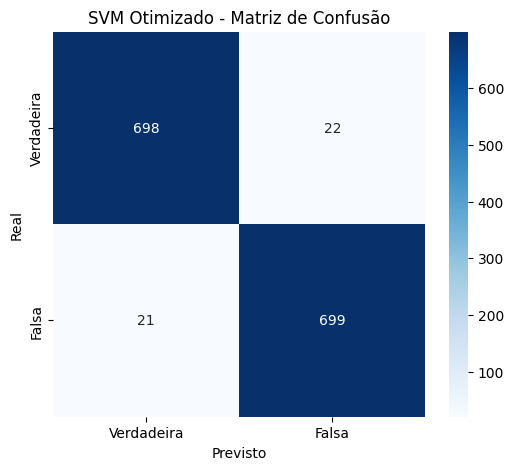

Relatório de Classificação - Random Forest Otimizado
              precision    recall  f1-score   support

       falsa       0.96      0.96      0.96       720
  verdadeira       0.96      0.96      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



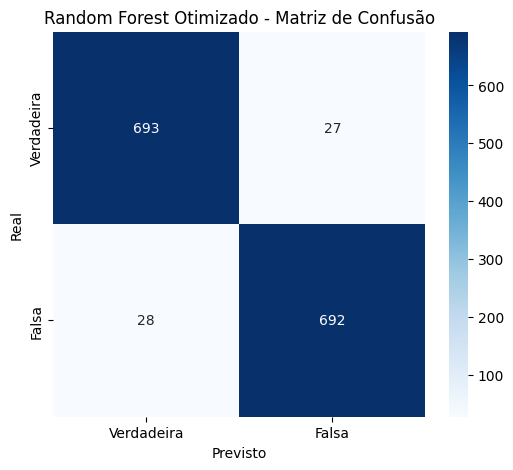

Relatório de Classificação - Naive Bayes Otimizado
              precision    recall  f1-score   support

       falsa       0.91      0.86      0.88       720
  verdadeira       0.87      0.91      0.89       720

    accuracy                           0.89      1440
   macro avg       0.89      0.89      0.89      1440
weighted avg       0.89      0.89      0.89      1440



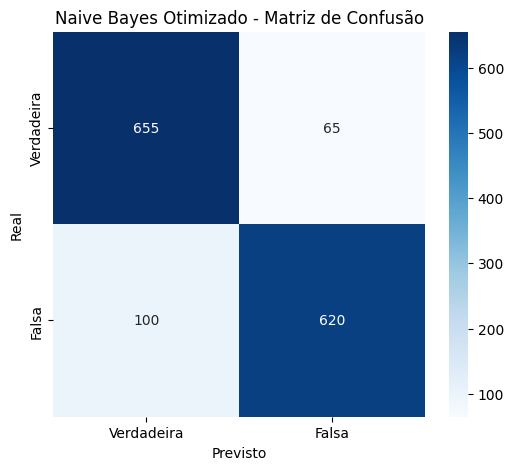


Análise de Erros do Random Forest
O modelo Random Forest errou 55 de 1440 previsões.

Exemplos de notícias VERDADEIRAS que o modelo classificou como FALSAS (Falsos Positivos):


,texto_original,classe_real,previsao_rf
index,,,
4512,pats empresas oferecem vagas emprego cidades r...,verdadeira,falsa
4319,luz estadio maracana cortada divida r milhoes ...,verdadeira,falsa
7078,ativista responde piada considerada gordofobic...,verdadeira,falsa
4611,brasil bloqueia milhoes numeros celulares quan...,verdadeira,falsa
5022,temer sanciona vetos parcelamento dividas prev...,verdadeira,falsa



Exemplos de notícias FALSAS que o modelo classificou como VERDADEIRAS (Falsos Negativos):


,texto_original,classe_real,previsao_rf
index,,,
3275,curcuma medica americana divulga receita natur...,falsa,verdadeira
2109,internauta escreve sobre cinismo hipocrisia mu...,falsa,verdadeira
1881,dilma revolta apos planalto divulgar gastos al...,falsa,verdadeira
268,lista fachin incriminados ligados mbl moviment...,falsa,verdadeira
3013,lula corrupto afirma laudo policia federal cas...,falsa,verdadeira


In [7]:
# Avaliação e Análise de Erros dos Modelos Clássicos

def avaliar_e_plotar(y_true, y_pred, model_name):
    """Exibe o relatório de classificação e plota a matriz de confusão para um modelo."""
    print("=" * 40)
    print(f"Relatório de Classificação - {model_name}")
    print("=" * 40)
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=["verdadeira", "falsa"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Verdadeira", "Falsa"],
                yticklabels=["Verdadeira", "Falsa"])
    plt.title(f"{model_name} - Matriz de Confusão")
    plt.ylabel("Real")
    plt.xlabel("Previsto")
    plt.show()

# Faz as previsões no conjunto de teste com os modelos otimizados.
y_pred_svm = best_svm.predict(X_test_tfidf)
y_pred_rf = best_rf.predict(X_test_tfidf)
y_pred_nb = best_nb.predict(X_test_tfidf)

# Avalia cada modelo.
avaliar_e_plotar(y_test, y_pred_svm, "SVM Otimizado")
avaliar_e_plotar(y_test, y_pred_rf, "Random Forest Otimizado")
avaliar_e_plotar(y_test, y_pred_nb, "Naive Bayes Otimizado")

# Análise de Erros Sistemática (Exemplo com Random Forest)
print("\n" + "="*100)
print("Análise de Erros do Random Forest")
print("="*100)

df_resultados_rf = pd.DataFrame({
    'texto_original': X_test.index.map(df['texto']),
    'classe_real': y_test,
    'previsao_rf': y_pred_rf
})
df_erros_rf = df_resultados_rf[df_resultados_rf['classe_real'] != df_resultados_rf['previsao_rf']]

print(f"O modelo Random Forest errou {len(df_erros_rf)} de {len(df_resultados_rf)} previsões.")
if not df_erros_rf.empty:
    print("\nExemplos de notícias VERDADEIRAS que o modelo classificou como FALSAS (Falsos Positivos):")
    display(df_erros_rf[df_erros_rf['classe_real'] == 'verdadeira'].head())

    print("\nExemplos de notícias FALSAS que o modelo classificou como VERDADEIRAS (Falsos Negativos):")
    display(df_erros_rf[df_erros_rf['classe_real'] == 'falsa'].head())

In [ ]:
# Salvando os Modelos Clássicos e o Vetorizador

# Cria um diretório para salvar os modelos
os.makedirs('../modelos_salvos', exist_ok=True)

# Salva o vetorizador TF-IDF, que é essencial para processar novas entradas
joblib.dump(vectorizer, '../modelos_salvos/vetorizador_tfidf.pkl')

# Salva cada um dos modelos clássicos otimizados
joblib.dump(best_svm, '../modelos_salvos/modelo_svm.pkl')
joblib.dump(best_rf, '../modelos_salvos/modelo_rf.pkl')
joblib.dump(best_nb, '../modelos_salvos/modelo_nb.pkl')

print("Modelos clássicos e vetorizador foram salvos no diretório 'modelos_salvos/'")

Modelos clássicos e vetorizador foram salvos no diretório 'modelos_salvos/'


In [9]:
# Preparação dos Dados para o BERT

# Carrega o tokenizador do BERT específico para português.
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

# Mapeia os rótulos de texto para o formato numérico esperado pelo PyTorch.
labels_map = {'verdadeira': 0, 'falsa': 1}
labels = df['classe'].map(labels_map).values

# Tokeniza todos os textos do dataset.
max_len = 128
input_ids = []
attention_masks = []

for text in df['texto'].values:
    encoded_dict = tokenizer.encode_plus(
                        text, add_special_tokens=True, max_length=max_len,
                        padding='max_length', truncation=True,
                        return_attention_mask=True, return_tensors='pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Concatena a lista de tensores em um único tensor.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Divisão em Treino, Validação e Teste
# Uma divisão tripartite é a melhor prática. O modelo é treinado nos dados de treino, ajustado com base no desempenho no conjunto de validação, e a avaliação final e imparcial é feita no conjunto de teste.
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Cria os DataLoaders para carregar os dados em lotes (batches) durante o treino.
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print(f"Dados para o BERT divididos em: {len(train_dataset)} para treino, {len(val_dataset)} para validação e {len(test_dataset)} para teste.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

Dados para o BERT divididos em: 5760 para treino, 720 para validação e 720 para teste.


In [ ]:
# Treinamento e Validação do Modelo BERT

# Carrega o modelo BERT pré-treinado com uma camada de classificação no topo.
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=2
)
model.to(device)

# Define o otimizador e o scheduler da taxa de aprendizado.
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loop de treinamento
for epoch_i in range(0, epochs):
    print(f'\n======== Época {epoch_i + 1} / {epochs} ========')
    print('Treinando...')
    total_train_loss = 0
    model.train() # Ativa o modo de treinamento

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"\n  Perda (loss) média no treino: {avg_train_loss:.2f}")

    # Etapa de Validação
    print("\nValidando no conjunto de validação...")
    model.eval() # Ativa o modo de avaliação
    total_eval_accuracy = 0

    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        total_eval_accuracy += (preds == b_labels).cpu().numpy().mean()

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print(f"  Acurácia na validação: {avg_val_accuracy:.2f}")

# Salva o modelo BERT treinado
torch.save(model.state_dict(), '../modelos_salvos/modelo_bert.bin')
print("\nTreinamento do BERT concluído e modelo salvo!")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


======== Época 1 / 2 ========
Treinando...

  Perda (loss) média no treino: 0.32

Validando no conjunto de validação...
  Acurácia na validação: 0.93

======== Época 2 / 2 ========
Treinando...

  Perda (loss) média no treino: 0.12

Validando no conjunto de validação...
  Acurácia na validação: 0.94

Treinamento do BERT concluído e modelo salvo!



Avaliando o modelo BERT no conjunto de teste (dados nunca vistos)...
Relatório de Classificação - BERT (Teste Final)
              precision    recall  f1-score   support

       falsa       0.91      0.97      0.94       361
  verdadeira       0.96      0.90      0.93       359

    accuracy                           0.93       720
   macro avg       0.94      0.93      0.93       720
weighted avg       0.94      0.93      0.93       720



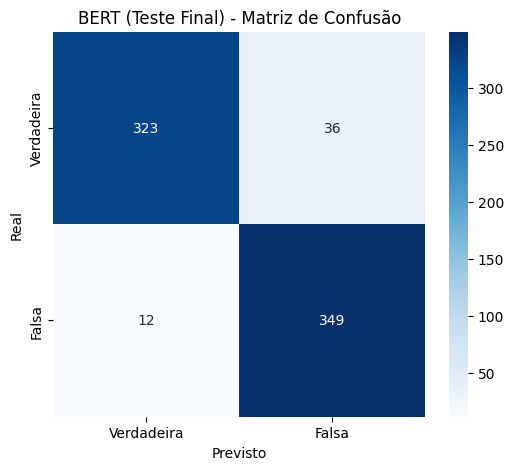

In [11]:
# Avaliação Final do Modelo BERT no Conjunto de Teste

print("\nAvaliando o modelo BERT no conjunto de teste (dados nunca vistos)...")
model.eval()

predictions, true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(np.argmax(logits, axis=1).flatten())
    true_labels.append(label_ids)

flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

rev_labels_map = {0: 'verdadeira', 1: 'falsa'}
y_pred_bert = [rev_labels_map[i] for i in flat_predictions]
y_test_bert = [rev_labels_map[i] for i in flat_true_labels]

# Usa a função de avaliação modular criada anteriormente
avaliar_e_plotar(y_test_bert, y_pred_bert, "BERT (Teste Final)")

Tabela Comparativa de Desempenho dos Modelos


,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
SVM Otimizado,0.970139,0.969487,0.970833,0.970160
Random Forest Otimizado,0.961806,0.962448,0.961111,0.961779
Naive Bayes Otimizado,0.885417,0.905109,0.861111,0.882562
BERT,0.933333,0.906494,0.966759,0.935657


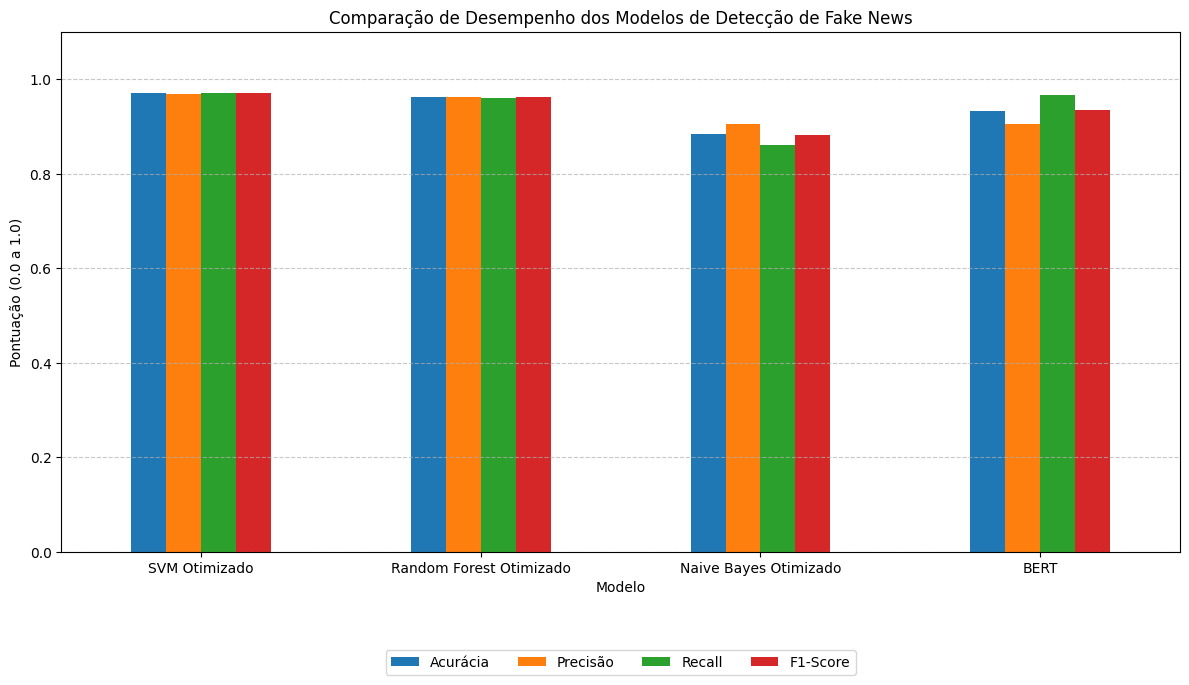

In [12]:
# Comparação Final de Todos os Modelos

def get_metrics(y_true, y_pred, model_name, pos_label='falsa'):
    """Retorna um dicionário com as métricas de avaliação."""
    return {
        "Modelo": model_name,
        "Acurácia": accuracy_score(y_true, y_pred),
        "Precisão": precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
        "Recall": recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    }

# Coleta as métricas de todos os modelos para comparação
resultados = [
    get_metrics(y_test, y_pred_svm, "SVM Otimizado"),
    get_metrics(y_test, y_pred_rf, "Random Forest Otimizado"),
    get_metrics(y_test, y_pred_nb, "Naive Bayes Otimizado"),
    get_metrics(y_test_bert, y_pred_bert, "BERT")
]

df_resultados = pd.DataFrame(resultados).set_index("Modelo")

print("Tabela Comparativa de Desempenho dos Modelos")
display(df_resultados)

# Gera o gráfico comparativo final
df_resultados.plot(kind="bar", figsize=(12, 7), rot=0)
plt.title("Comparação de Desempenho dos Modelos de Detecção de Fake News")
plt.ylabel("Pontuação (0.0 a 1.0)")
plt.ylim(0, 1.1)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Teste Interativo com Novas Entradas

# Carregando os modelos salvos para a função de previsão
# Isso simula como uma aplicação real usaria os modelos, sem retreiná-los.

print("Carregando modelos salvos para a função de previsão...")
# Carrega modelos clássicos
loaded_vectorizer = joblib.load('../modelos_salvos/vetorizador_tfidf.pkl')
loaded_svm = joblib.load('../modelos_salvos/modelo_svm.pkl')
loaded_rf = joblib.load('../modelos_salvos/modelo_rf.pkl')
loaded_nb = joblib.load('../modelos_salvos/modelo_nb.pkl')

# Carrega modelo BERT
loaded_bert_model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", num_labels=2
)
loaded_bert_model.load_state_dict(torch.load('../modelos_salvos/modelo_bert.bin'))
loaded_bert_model.to(device)
loaded_bert_model.eval()

# Mapeamento reverso para a saída do BERT
rev_labels_map = {0: 'verdadeira', 1: 'falsa'}

def prever_noticia(texto):
    """
    Recebe um texto e retorna a previsão dos quatro modelos treinados,
    utilizando os artefatos salvos em disco.
    """
    print("=" * 60)
    print(f"Analisando: '{texto[:100]}...'")
    print("-" * 60)

    # --- Previsão com modelos clássicos ---
    texto_limpo = preprocess_text(texto)
    texto_vetorizado = loaded_vectorizer.transform([texto_limpo])

    print(f"Previsão (SVM): {loaded_svm.predict(texto_vetorizado)[0].upper()}")
    print(f"Previsão (Random Forest): {loaded_rf.predict(texto_vetorizado)[0].upper()}")
    print(f"Previsão (Naive Bayes): {loaded_nb.predict(texto_vetorizado)[0].upper()}")

    # --- Previsão com BERT ---
    encoded_text = tokenizer.encode_plus(
        texto, max_length=128, add_special_tokens=True, return_token_type_ids=False,
        padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
    )
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        outputs = loaded_bert_model(input_ids, attention_mask=attention_mask)

    prediction = torch.argmax(outputs.logits, dim=1).item()
    print(f"Previsão (BERT): {rev_labels_map[prediction].upper()}")
    print("=" * 60)

# --- EXEMPLOS DE USO ---
noticia_falsa_exemplo = "Urgente: Cientistas descobrem que o consumo diário de água com limão previne todos os tipos de câncer, mas a indústria farmacêutica esconde isso."
noticia_verdadeira_exemplo = "O IBGE divulgou hoje os dados da inflação oficial, medida pelo IPCA, que apresentou uma leve alta no último mês, pressionada pelo aumento nos preços dos combustíveis."

prever_noticia(noticia_falsa_exemplo)
prever_noticia(noticia_verdadeira_exemplo)

Carregando modelos salvos para a função de previsão...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analisando: 'Urgente: Cientistas descobrem que o consumo diário de água com limão previne todos os tipos de cânce...'
------------------------------------------------------------
Previsão (SVM): FALSA
Previsão (Random Forest): FALSA
Previsão (Naive Bayes): FALSA
Previsão (BERT): FALSA
Analisando: 'O IBGE divulgou hoje os dados da inflação oficial, medida pelo IPCA, que apresentou uma leve alta no...'
------------------------------------------------------------
Previsão (SVM): FALSA
Previsão (Random Forest): FALSA
Previsão (Naive Bayes): VERDADEIRA
Previsão (BERT): FALSA
